# Adaptive Frank-Wolf method for Relative-Error problems
## Problem formulation

PageRank[1] problem for Frank-Wolf methods is shown below:

$$
f(x) = \frac{1}{2}\left\lVert{Ax}\right\rVert_2^2 \to \min_{x\in\Delta^n_{1}}
$$

, where:

$$
A = I - P^\intercal
$$

$I$ – identity matrix of size $n\times n$, $P$ – stochastic transit matrix, $P \in \R^{n\times n}$

Gradient of the given function is represented below:

$$
\nabla f(x) = A^\intercal A x
$$

[1]: Efficient numerical methods to solve sparse linear equations with application to PageRank, Anikin A., Gasnikov A., et al, 2022


#  Implementation of Adaptive Frank-Wolfe algorithm with Erroneous Conditional Oracle

In [1]:
import numpy as np

# Visualization
import matplotlib.pyplot as plt

In [2]:
from aecg import AECG
from helper import Objective, PageRankObjective
from helper import BoxSetLMO
from helper import CWEOracle
from helper import StepSizeStrategy

# Configure `seed` for reproducibility of the solution
np.random.seed(2025)

# Size of the problem
n = 100

# Relative Error [0; 0.5)
eps = 1e-14

# Objective parameters
A = np.random.randn(n, n)
A = A / A.sum(axis=1, keepdims=True)  # Normalize rows for PageRank

# Box Set properties
lower_bound = np.zeros(n)
upper_bound = np.ones(n)

# Objective function
objective = PageRankObjective(A)

# Number of iterations
max_iterations = 150

# Coordinate-wise erroneous oracle
erroneous_oracle = CWEOracle(epsilon=eps)

# Linear minimization oracle
linear_minimization_oracle = BoxSetLMO(lower_bound=lower_bound, upper_bound=upper_bound)

# Starting point
w0 = np.random.uniform(lower_bound, upper_bound)

# M
M = 10

# R
R = 15

# Lipschitz-gradient constant
L = np.linalg.eigvals(A).max()
L


# Helper function for creating algorithm with given step size.
def create_algorithm(label: str, step_size: StepSizeStrategy) -> AECG:
    return AECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        step_size=step_size,
        keep_history=True,
    )

## Scenario with iteration-dependent step-size.

Let the step size is dependent on iteration number $t$:

$$
\eta_t = \frac{2}{t + 2}, \forall t \geqslant 0
$$

**Convergence rate:**

$$
f^t - f^* \leqslant \varepsilon M R + \frac{4\max\limits_t L_t \cdot R^2}{t + 2}
$$

, where

$$
L_t = \frac{2 \cdot (f^{t+1} - f^t - {\eta_t\langle \hat{g^t}, p^{t+1} \rangle})}{\eta_t^2\lVert p^{t + 1}\rVert^2}
$$

## Case 1. $L_t \leqslant c \cdot L$

### Stopping criterion

$$
f^{t+1} - f^{t} \leqslant \eta_t \langle\hat{g^t}, p^{t+1}\rangle + \frac{L_t \cdot \eta_t^2}{2}||p^{t+1}||^2 \leqslant\\
\leqslant \frac{2}{t + 2} \langle\hat{g^t}, p^{t+1}\rangle + \frac{4 L_t R^2}{(t + 2)^2}
$$
, where $R := ||p^{t+1}||$

## Case 2. $L_t \geqslant L$

**Stopping criterion:**

$$
f^{t + 1} - f^t \leqslant \frac{2}{t+2} \langle\hat{g^t}, p^{t+1}\rangle + \frac{2\varepsilon M R}{t + 2} + \frac{4\max\limits_t{L_t} \cdot R^2}{(t + 2)^2} + \frac{2\varepsilon M R}{t + 2} \leqslant\\
\leqslant \frac{2}{t+2} \langle\hat{g^t}, p^{t+1}\rangle + \frac{4 \varepsilon M R}{t + 2} + \frac{4\max\limits_t{L_t} \cdot R^2}{(t + 2)^2}
$$

In [3]:
from helper import DynamicDecayingStepSizeStrategy

step_size_strategy = DynamicDecayingStepSizeStrategy(epsilon=eps, L_0=L, M=M, R=R)

In [4]:
# Solve for iteration dependent step size
from helper import ConstantDecayingStepSizeStrategy


class StepSizeWrapper:
    """
    A wrapper for |DecayingStepSizeStrategy| to print table of
    intermediate results.
    """

    _L: float
    _wrappee: StepSizeStrategy

    def __init__(self, wrappee: StepSizeStrategy, L: float):
        self._wrappee = wrappee
        self._L = L
        self._print_table(r"$    t     L_t    L$")

    def __call__(
        self,
        t: int,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> float:
        return self._wrappee(t, g_hat, p)

    def adjust(self):
        self._wrappee.adjust()

    def adapt(self):
        self._wrappee.adapt()

    def is_adapted(
        self,
        t: int,
        objective: Objective,
        w: np.ndarray,
        w_next: np.ndarray,
    ) -> bool:
        result = self._wrappee.is_adapted(
            t, objective, w, w_next
        )
        self._print_table(f"{t:6d} {self._wrappee._Lt:10.3e} {self._L:10.1f}")
        return result

    def _print_table(self, row: str):
        if False:
            print(row)


In [5]:
constant_algorithm = create_algorithm(
    label=r"$L_t \geqslant L$",
    step_size=StepSizeWrapper(ConstantDecayingStepSizeStrategy(eps, L, M, R), L),
)

w = constant_algorithm.solve(w0)
w

array([0.49537347, 0.49713741, 0.49737118, 0.49708263, 0.50537275,
       0.50314838, 0.49903547, 0.49707502, 0.50640061, 0.50604612,
       0.50166795, 0.50429909, 0.49386351, 0.50685594, 0.50603219,
       0.50167144, 0.50225518, 0.49628961, 0.50352796, 0.49485169,
       0.50555271, 0.5043719 , 0.49756675, 0.49841805, 0.5021524 ,
       0.49710451, 0.49607019, 0.49506668, 0.5041021 , 0.49482316,
       0.493018  , 0.50354817, 0.5062741 , 0.49720543, 0.50047936,
       0.50338139, 0.49800718, 0.49580819, 0.49725425, 0.50111078,
       0.49595438, 0.49669301, 0.50580926, 0.50218865, 0.49867092,
       0.50295226, 0.49334889, 0.50365392, 0.4990497 , 0.50520531,
       0.49889551, 0.50046749, 0.5057089 , 0.49798805, 0.50498456,
       0.49445969, 0.50071605, 0.49870443, 0.49344462, 0.50481228,
       0.49732237, 0.49691767, 0.5068455 , 0.49393331, 0.50120241,
       0.50305306, 0.50686617, 0.50602373, 0.49884069, 0.50327891,
       0.49737169, 0.50288183, 0.49888271, 0.50241855, 0.50087

In [6]:
dynamic_algorithm = create_algorithm(
    label=r"$L_t \leqslant c \cdot L$",
    step_size=StepSizeWrapper(DynamicDecayingStepSizeStrategy(eps, L, M, R), L),
)

w = dynamic_algorithm.solve(w0)
w

array([0.49490459, 0.4973588 , 0.49768405, 0.49728259, 0.50613364,
       0.50303882, 0.49999963, 0.497272  , 0.50756374, 0.50707052,
       0.50097906, 0.50463983, 0.49280375, 0.50819724, 0.50705113,
       0.50098391, 0.50179609, 0.49617924, 0.50356693, 0.49417862,
       0.50638403, 0.50474114, 0.49795616, 0.49914059, 0.50165308,
       0.49731303, 0.49587396, 0.49447775, 0.50436576, 0.49413892,
       0.49162737, 0.50359506, 0.50738772, 0.49745344, 0.49932535,
       0.50336301, 0.49856894, 0.49550944, 0.49752136, 0.50020386,
       0.49571282, 0.4967405 , 0.50674097, 0.50170352, 0.49949242,
       0.50276595, 0.49208775, 0.50374219, 0.50001942, 0.50590068,
       0.4998049 , 0.49930883, 0.50660134, 0.49854232, 0.50559354,
       0.49363323, 0.49965465, 0.49953904, 0.49222093, 0.50535385,
       0.49761614, 0.49705307, 0.50818272, 0.49290086, 0.50033134,
       0.5029062 , 0.50821148, 0.50703937, 0.49972863, 0.50322043,
       0.49768477, 0.50266796, 0.49978709, 0.50202339, 0.49987

## Results

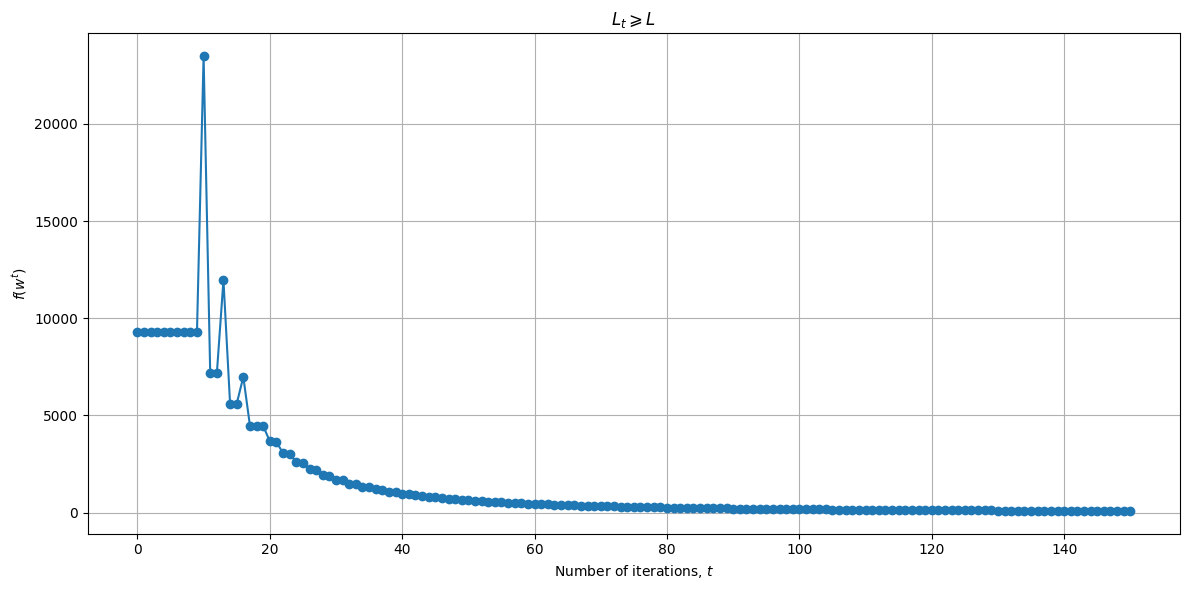

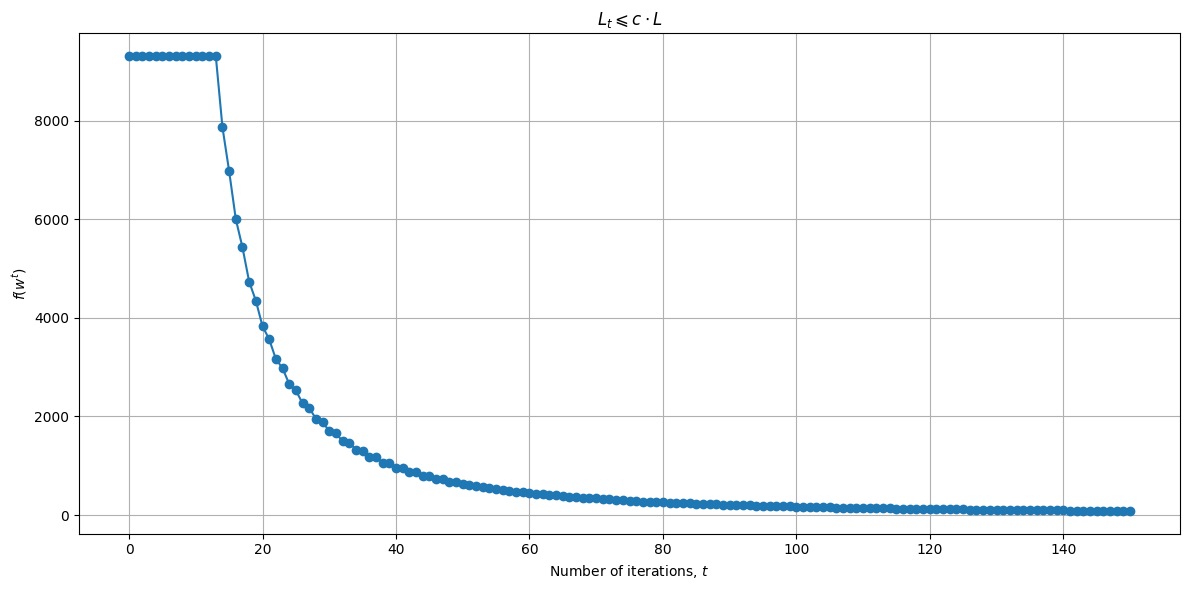

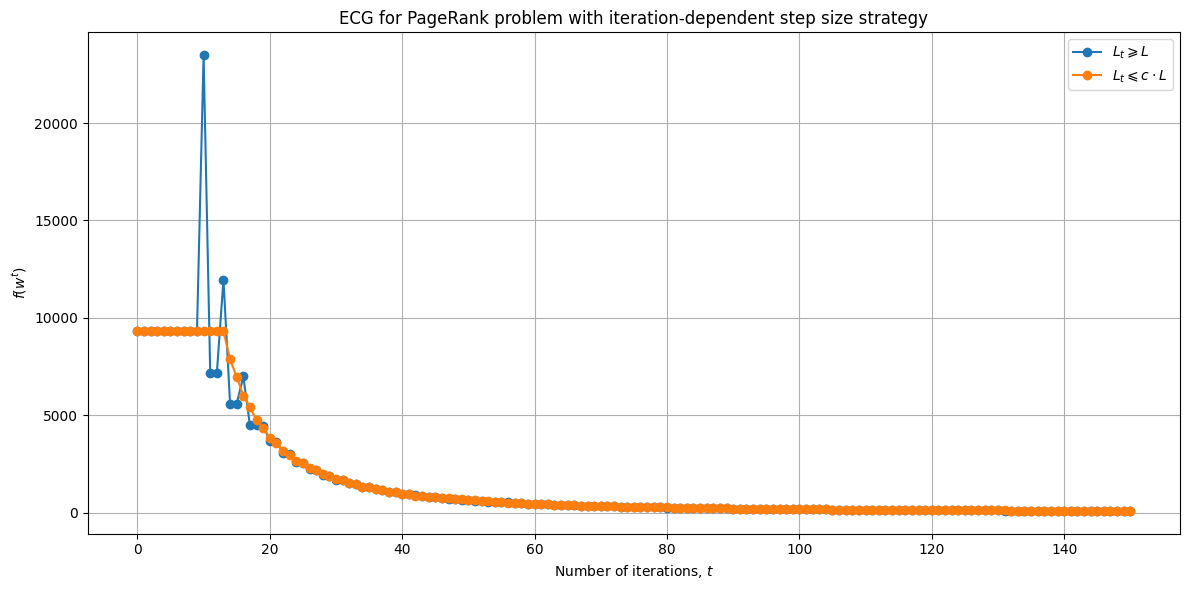

In [7]:
algorithms = [constant_algorithm, dynamic_algorithm]

# Comparison of results
for algorithm in algorithms:
    plt.figure(figsize=(12, 6))
    values = [objective(w) for w, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.title(algorithm.label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
for algorithm in algorithms:
    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

plt.title(r"ECG for PageRank problem with iteration-dependent step size strategy")
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$f(w^t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Interactive example for $c \cdot L_t$ values
import ipywidgets as widgets
from IPython.display import display


def update_plot(c: int):
    algorithm = create_algorithm(
        label=r"$c \cdot L_t$ dependent step size",
        step_size=DynamicDecayingStepSizeStrategy(eps, c * L, M, R),
    )
    algorithm.solve(w0)

    plt.figure(figsize=(12, 6))

    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

    plt.title(r"$L_t = {:.2f} \cdot L$".format(c))
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create sliders
slider_c = widgets.FloatSlider(value=2.0, min=1, max=10.0, step=1, description="c:")

# Register the update_plot function as the callback for each slider using interactive
interactive_plot = widgets.interactive(update_plot, c=slider_c)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=2.0, description='c:', max=10.0, min=1.0, step=1.0), Output()), _dom_c…